In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

* standard pytorch workflow
1. prep the data
2. build the model
3. fit the model to the data (training)
4. make predictions and eval model (inference)
5. save and load the model

* machine learning is:
1. turning your data into numbers
2. finding or building the best model to represent that data

In [3]:
weight = 0.7
bias = 0.3

start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [4]:
train_split = int(0.8 * len(X)) # 80% of the data for training, 20% for testing
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

* the model will learn the relationship between X_train and y_train

In [5]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  plt.figure(figsize=(10, 7))
  dot_size = 8

  plt.scatter(train_data, train_labels, c="b", s=dot_size, label="Training data")
  plt.scatter(test_data, test_labels, c="g", s=dot_size, label="Testing data")
  if predictions is not None:
    plt.scatter(test_data, predictions, c="r", s=dot_size, label="Predictions")

  plt.legend(prop={"size": 14})

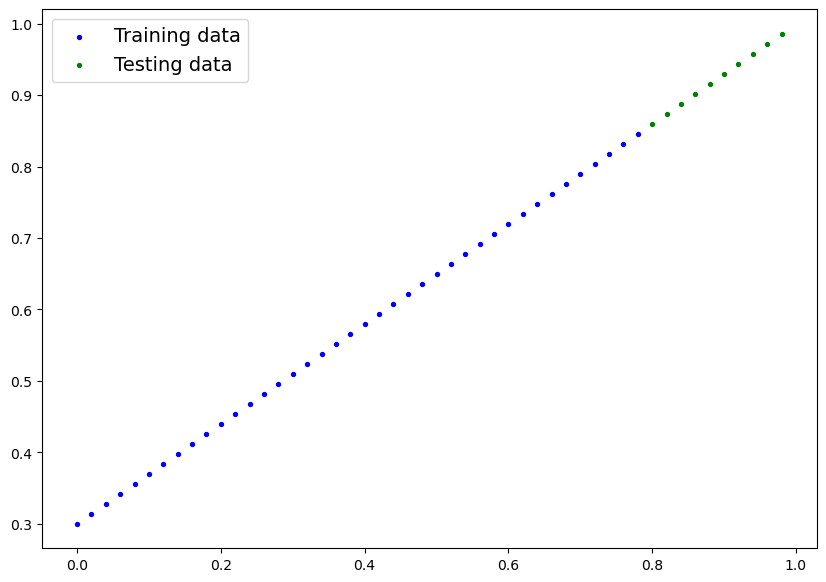

In [6]:
plot_predictions() # visualize, visualize, visualize! become one with the data.

In [7]:
class LinearRegressionModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.weights = nn.Parameter(torch.randn(1,
                                            dtype=torch.float,
                                            requires_grad=True))
    self.bias = nn.Parameter(torch.randn(1,
                                         dtype=torch.float,
                                         requires_grad=True))

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.weights * x + self.bias # this is the linear regression formula

* torch.nn contains all of the building blocks for building computational graphs
* torch.nn.Parameter stores tensors that can be used in torch.nn
* torch.nn.Module is the parent class of all models you will be building
* torch.optim contains various optimization algorithms to best improve gradient descent and in turn reduce the models loss
* the forward method is required for all torch.nn.Modules sub-classes

In [8]:
torch.manual_seed(42)
model0 = LinearRegressionModel()
list(model0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [9]:
with torch.inference_mode(): # makes forward passes faster by not requiring storing grads and such
  y_preds = model0(X_test)
print(f"Num of test samples: {len(X_test)}")
print(f"Num of predictions made: {len(y_preds)}")
print(f"Predicted vals: \n{y_preds}")
print(f"State dict: \n{model0.state_dict()}")

Num of test samples: 10
Num of predictions made: 10
Predicted vals: 
tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])
State dict: 
OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])


tensor([[0.4618],
        [0.4691],
        [0.4764],
        [0.4836],
        [0.4909],
        [0.4982],
        [0.5054],
        [0.5127],
        [0.5200],
        [0.5272]])


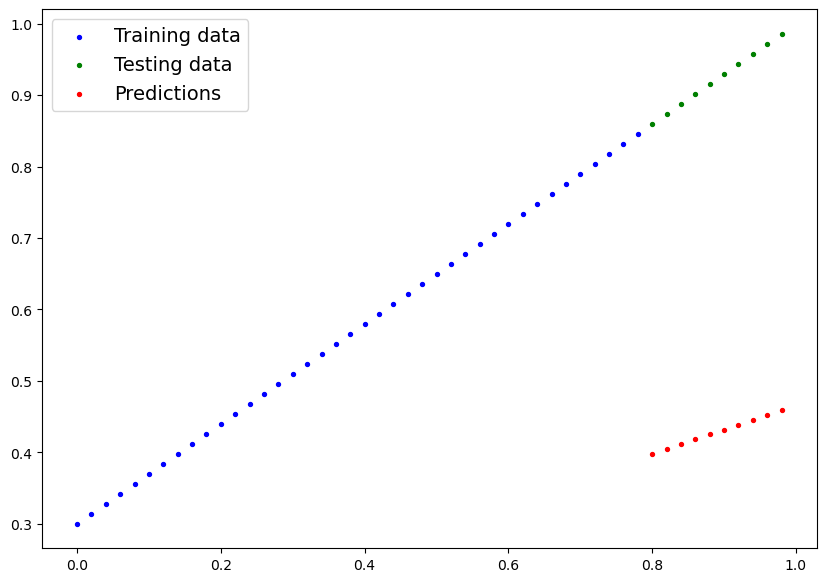

In [10]:
plot_predictions(predictions=y_preds)
print(y_test - y_preds)

* loss function: measures how wrong the model is. the lower the better
* most common one is mean absolute error and binary cross entropy
* optimizer: tells model how to update internal params to best lower the loss
* stochastic gradient descent and adam optimizer are the most well known

In [11]:
loss_fn = nn.L1Loss() # MAE loss is same as L1
optimizer = torch.optim.SGD(params=model0.parameters(),
                            lr=0.01)

#### Training loop
1. Forward pass: go through all calculations
2. Calculate the loss
3. Zero the gradients of the optimizer so they can be recalculated for the specific training step
4. Backpropogation on loss: build the computational graph of gradients for all parameters
5. Update the optimizer: updates the gradients with respect to the loss gradients

In [12]:
epochs = 300
train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(epochs):
  model0.train() # put model in training mode

  y_pred = model0(X_train)
  loss = loss_fn(y_pred, y_train)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step() # progress optimizer

  model0.eval() # put model in evalation mode

  with torch.inference_mode():
    test_pred = model0(X_test)
    test_loss = loss_fn(test_pred, y_test.type(torch.float))

    if epoch % 10 == 0:
      epoch_count.append(epoch)
      train_loss_values.append(loss.detach().numpy())
      test_loss_values.append(test_loss.detach().numpy())
      print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss}")

Epoch: 0 | MAE Train Loss: 0.31288138031959534 | MAE Test Loss: 0.48106518387794495
Epoch: 10 | MAE Train Loss: 0.1976713240146637 | MAE Test Loss: 0.3463551998138428
Epoch: 20 | MAE Train Loss: 0.08908725529909134 | MAE Test Loss: 0.21729660034179688
Epoch: 30 | MAE Train Loss: 0.053148526698350906 | MAE Test Loss: 0.14464017748832703
Epoch: 40 | MAE Train Loss: 0.04543796554207802 | MAE Test Loss: 0.11360953003168106
Epoch: 50 | MAE Train Loss: 0.04167863354086876 | MAE Test Loss: 0.09919948130846024
Epoch: 60 | MAE Train Loss: 0.03818932920694351 | MAE Test Loss: 0.08886633068323135
Epoch: 70 | MAE Train Loss: 0.03476089984178543 | MAE Test Loss: 0.0805937647819519
Epoch: 80 | MAE Train Loss: 0.03132382780313492 | MAE Test Loss: 0.07232122868299484
Epoch: 90 | MAE Train Loss: 0.02788739837706089 | MAE Test Loss: 0.06473556160926819
Epoch: 100 | MAE Train Loss: 0.024458957836031914 | MAE Test Loss: 0.05646304413676262
Epoch: 110 | MAE Train Loss: 0.021020207554101944 | MAE Test Loss:

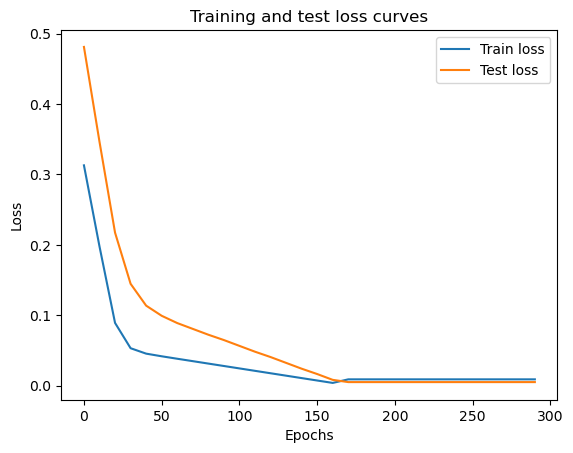

In [13]:
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])


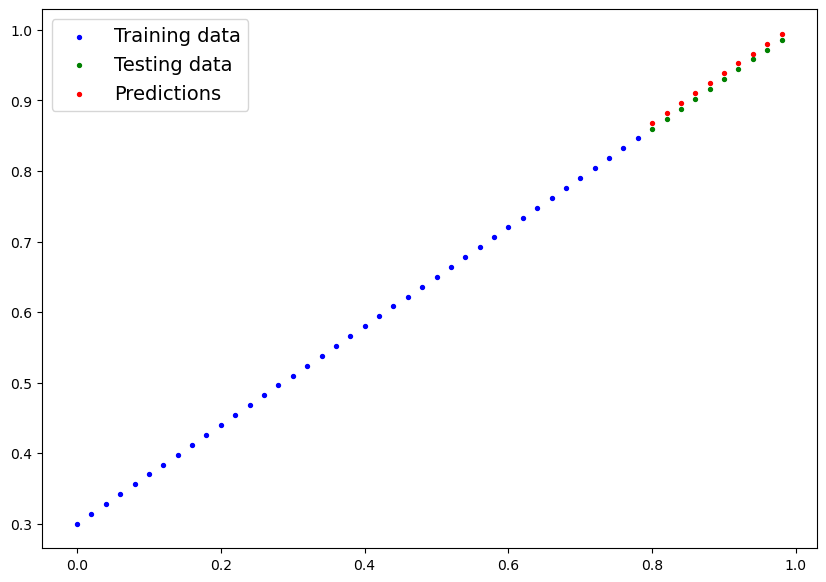

In [14]:
model0.eval()

with torch.inference_mode():
  #model0.to(device)
  #X_test = X_test.to(device)
  y_preds = model0(X_test)
print(y_preds)
plot_predictions(predictions=y_preds)

#### Saving models
* torch.save
* torch.load
* torch.nn.Module.load_state_dict

In [15]:
from pathlib import Path

# create dir
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# create model save path
MODEL_NAME = "01_pytorch_workflow_model0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# save model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model0.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model0.pth


* loading models saved with sate_dict()

In [16]:
loaded_model0 = LinearRegressionModel()
loaded_model0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [19]:
loaded_model0.eval()

with torch.inference_mode():
    loaded_model_preds = loaded_model0(X_test)
    
y_preds == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

#### Now device agnostic model (GPU when available, else CPU)

In [20]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cpu


In [21]:
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias 

In [22]:
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

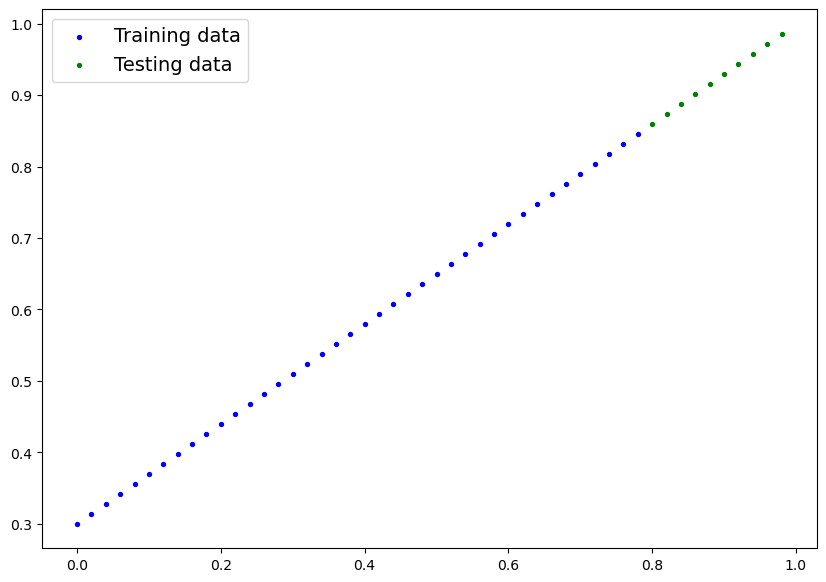

In [23]:
plot_predictions(X_train, y_train, X_test, y_test)

In [25]:
class LinearRegressionModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_layer = nn.Linear(in_features=1, 
                                      out_features=1)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)

torch.manual_seed(42)
model_1 = LinearRegressionModelV2()
model_1, model_1.state_dict()

(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [26]:
model_1.to(device) 
next(model_1.parameters()).device

device(type='cpu')

In [27]:
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.01)

In [28]:
torch.manual_seed(42)

# Set the number of epochs 
epochs = 1000 

# Put data on the available device
# Without this, error will happen (not all model/data on device)
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
    ### Training
    model_1.train() # train mode is on by default after construction

    # 1. Forward pass
    y_pred = model_1(X_train)

    # 2. Calculate loss
    loss = loss_fn(y_pred, y_train)

    # 3. Zero grad optimizer
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Step the optimizer
    optimizer.step()

    ### Testing
    model_1.eval() # put the model in evaluation mode for testing (inference)
    # 1. Forward pass
    with torch.inference_mode():
        test_pred = model_1(X_test)
    
        # 2. Calculate the loss
        test_loss = loss_fn(test_pred, y_test)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Train loss: {loss} | Test loss: {test_loss}")

Epoch: 0 | Train loss: 0.5551779866218567 | Test loss: 0.5739762187004089
Epoch: 100 | Train loss: 0.006215679459273815 | Test loss: 0.014086711220443249
Epoch: 200 | Train loss: 0.0012645035749301314 | Test loss: 0.013801807537674904
Epoch: 300 | Train loss: 0.0012645035749301314 | Test loss: 0.013801807537674904
Epoch: 400 | Train loss: 0.0012645035749301314 | Test loss: 0.013801807537674904
Epoch: 500 | Train loss: 0.0012645035749301314 | Test loss: 0.013801807537674904
Epoch: 600 | Train loss: 0.0012645035749301314 | Test loss: 0.013801807537674904
Epoch: 700 | Train loss: 0.0012645035749301314 | Test loss: 0.013801807537674904
Epoch: 800 | Train loss: 0.0012645035749301314 | Test loss: 0.013801807537674904
Epoch: 900 | Train loss: 0.0012645035749301314 | Test loss: 0.013801807537674904


In [29]:
from pprint import pprint # pprint = pretty print, see: https://docs.python.org/3/library/pprint.html 
print("The model learned the following values for weights and bias:")
pprint(model_1.state_dict())
print("\nAnd the original values for weights and bias are:")
print(f"weights: {weight}, bias: {bias}")

The model learned the following values for weights and bias:
OrderedDict([('linear_layer.weight', tensor([[0.6968]])),
             ('linear_layer.bias', tensor([0.3025]))])

And the original values for weights and bias are:
weights: 0.7, bias: 0.3


In [30]:
# Turn model into evaluation mode
model_1.eval()

# Make predictions on the test data
with torch.inference_mode():
    y_preds = model_1(X_test)
y_preds

tensor([[0.8600],
        [0.8739],
        [0.8878],
        [0.9018],
        [0.9157],
        [0.9296],
        [0.9436],
        [0.9575],
        [0.9714],
        [0.9854]])

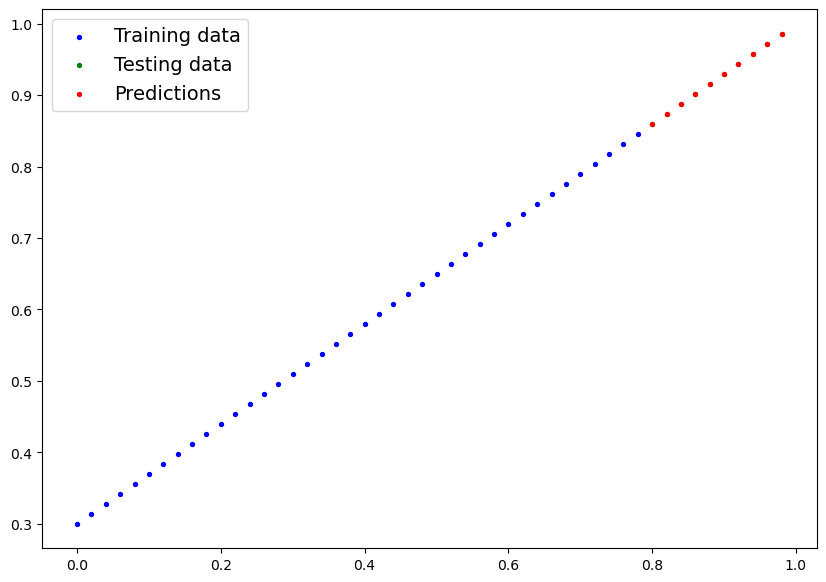

In [31]:
plot_predictions(predictions=y_preds.cpu())